<a href="https://colab.research.google.com/github/arvchak/MLProj/blob/main/protonetwork_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tensorflow
#!pip install tensornets

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import glob
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import pathlib
from PIL import Image
from numpy.linalg import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/tensorflow_datasets.zip

Streaming output truncated to the last 5000 lines.
  inflating: tensorflow_datasets/RESISC45/downloads/new_train/val/runway/runway_532.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/new_train/val/runway/runway_254.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/new_train/val/runway/runway_240.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/new_train/val/runway/runway_526.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/new_train/val/runway/runway_268.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/new_train/val/runway/runway_095.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/new_train/val/runway/runway_081.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/new_train/val/runway/runway_056.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/new_train/val/runway/runway_042.jpg  
  inflating: tensorflow_datasets/RESISC45/downloads/new_train/val/runway/runway_687.jpg  
  inflating: tensorflow_datasets/RESISC45/downloa

In [5]:
root_path = '/content/tensorflow_datasets/RESISC45/downloads/new_train'
output = '/content/tensorflow_datasets/RESISC45/downloads/new_train'

In [6]:
data_dir = pathlib.Path(root_path)
count =  len(list(data_dir.glob('*/*.jpg')))
print(count)

0


In [7]:
#!pip install split-folders
##import splitfolders
#splitfolders.ratio(root_path , output , seed = 42 , ratio = (.7, .2 ,.1), group_prefix = None)

In [8]:
data_dir_train = pathlib.Path(output+'/train')
data_dir_test = pathlib.Path(output+'/test')
data_dir_val = pathlib.Path(output+'/val')

In [9]:
batch_size = 45
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    image_size = (img_height, img_width), 
    batch_size = (batch_size))

Found 21000 files belonging to 30 classes.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_val, 
    image_size = (img_height, img_width), 
    batch_size = (batch_size))

Found 7000 files belonging to 10 classes.


In [11]:
class_names = train_ds.class_names
val_class_names = val_ds.class_names
print(class_names)
no_of_classes = len(class_names)
#train_np = np.stack(list(train_ds))

['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway']


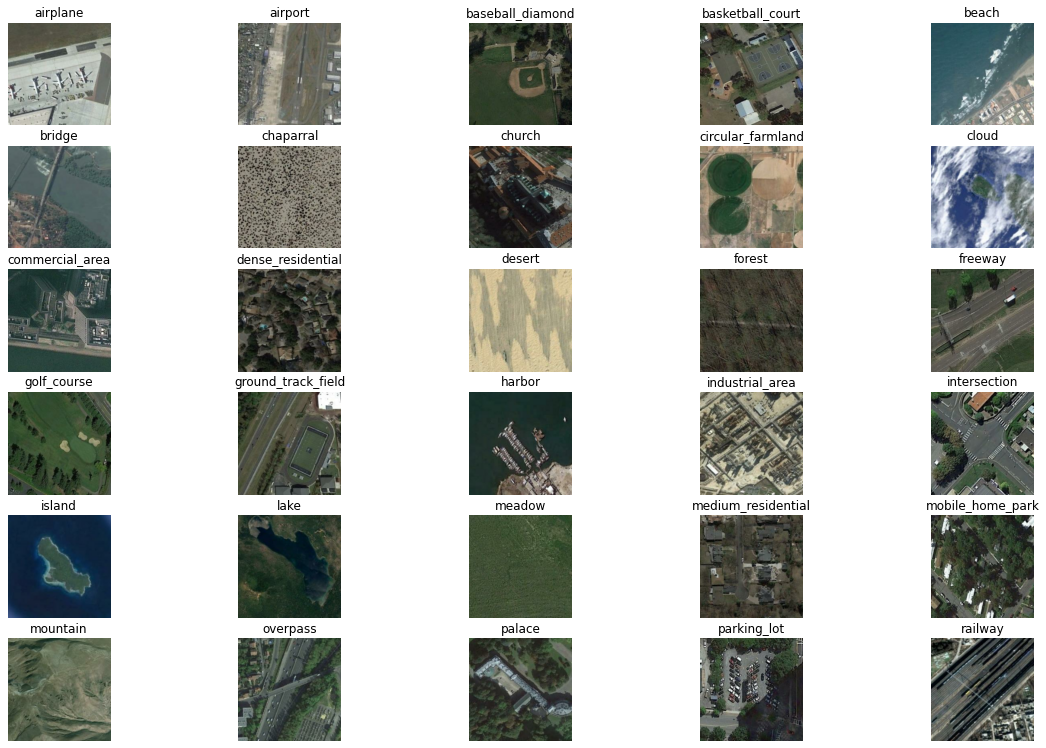

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
j = 0
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(9, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [13]:
#train_dataset = np.zeros([no_of_classes, 3, img_height, img_width], dtype=object)
examples = np.zeros([no_of_classes, 700, img_height, img_width,3], dtype=np.float32)
for train in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], train))
  for image, label in filtered_ds.take(1):
    img_files = sorted(glob.glob(os.path.join(data_dir_train , class_names[label.numpy()[0]], '*.jpg')))
    for index, img_file in enumerate(img_files):
      values =  np.array(Image.open(img_file).resize((img_width, img_height)), np.float32, copy=False)
      examples[label.numpy()[0], index] = values


In [14]:
test_data = np.zeros([10, 700, img_height, img_width,3], dtype=np.float32)
for val in range(len(val_class_names)):
  filtered_val_ds = val_ds.filter(lambda x, l: tf.math.equal(l[0], val))
  for image, label in filtered_val_ds.take(1):
    img_files = sorted(glob.glob(os.path.join(data_dir_val , val_class_names[label.numpy()[0]], '*.jpg')))
    for index, img_file in enumerate(img_files):
      values =  np.array(Image.open(img_file).resize((img_width, img_height)), np.float32, copy=False)
      test_data[label.numpy()[0], index] = values


In [15]:
tf.compat.v1.disable_eager_execution()

In [16]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


In [72]:
def base_model(inputs, h_dim , z_dim):
    layer_inputs = layers.Input(tensor = inputs)
    #x = img_augmentation(inputs)
    x = img_augmentation(layer_inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False
       # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)

    net = cnn(inputs, h_dim)
    net = cnn(net, h_dim)
    net = cnn(net, h_dim) 
    net = cnn(net, z_dim) 
    net = tf.keras.layers.Flatten()(net)
    

    # Rebuild top
    return tf.concat([x, net], axis = 1)

In [74]:
def cnn(inputs, op_channels):
    conv = tf.compat.v1.layers.conv2d(inputs, op_channels, kernel_size=3, padding='SAME')
    conv = tf.compat.v1.layers.batch_normalization(conv,scale=True, center=True)
    conv = tf.nn.relu(conv)
    conv = tf.compat.v1.layers.max_pooling2d(conv, strides = 2, pool_size=2, padding = 'SAME')
    return conv

In [75]:
def feature_embeddings(support_set , h_dim , z_dim):
    net = cnn(support_set, h_dim)
    net = cnn(net, h_dim)
    net = cnn(net, h_dim) 
    net = cnn(net, z_dim) 
    net = tf.keras.layers.Flatten()(net)
    return net

In [120]:
#number of classes
num_way = 5

#number of examples per class for support set
num_shot = 5

#number of query points
num_query = 5

#number of examples
num_examples = 10

channel = 3

h_dim = 64

z_dim = 64

In [121]:
support_set = tf.compat.v1.placeholder(tf.float32, [None, None, img_height, img_width, 3])
query_set = tf.compat.v1.placeholder(tf.float32, [None, None, img_height, img_width, 3])
label = tf.compat.v1.placeholder(tf.int64, [None, None])

In [122]:
support_set_shape = tf.shape(support_set)
query_set_shape = tf.shape(query_set)


In [123]:
num_classes, num_support_points = support_set_shape[0], support_set_shape[1]

In [124]:
num_query_points = query_set_shape[1]

In [125]:
y = tf.compat.v1.placeholder(tf.int64, [None, None])

#convert the label to one hot
y_one_hot = tf.one_hot(y, depth=num_classes)
print(y_one_hot.shape)


label_prime = tf.one_hot(label , depth = num_classes)

(None, None, None)


In [126]:
#output = build_model(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channel]))
support_set_embeddings = base_model(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channel]), h_dim, z_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.appl

In [127]:
embedding_dimension = tf.shape(support_set_embeddings)[-1]
class_prototype = tf.reduce_mean(tf.reshape(support_set_embeddings, [num_classes, num_support_points, embedding_dimension]), axis=1)

In [128]:
#query_output = build_model(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channel]))
query_set_embeddings = base_model(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channel]), h_dim, z_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.appl

In [129]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)
   
    

In [130]:
print(query_set_embeddings.shape)
print(class_prototype.shape)

distance = euclidean_distance(query_set_embeddings,class_prototype)
print(distance)

predicted_probability = tf.reshape(tf.nn.log_softmax(-distance), [num_classes, num_query_points, -1])
loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, predicted_probability), axis=-1), [-1]))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predicted_probability, axis=-1), y), tf.float32))

train = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


(None, 13824)
(None, 13824)
Tensor("Mean_13:0", shape=(None, None), dtype=float32)


In [131]:
sess = tf.compat.v1.InteractiveSession()
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()
sess.run(init)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [132]:
num_epochs = 100
num_episodes = 100

In [133]:
for epoch in range(num_epochs):
    
    for episode in range(num_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(no_of_classes)[:num_way]
        
        support = np.zeros([num_way, num_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([num_way, num_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:num_shot + num_query]
            support[index] = examples[class_, selected[:num_shot]]
            
            # 5 querypoints per classs
            query[index] = examples[class_, selected[num_shot:]]
            
        #=support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(num_way)[:, np.newaxis], (1, num_query)).astype(np.uint8)
        _, loss_, accuracy_ = sess.run([train, loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        
        if (episode+1) % 10 == 0:
            print('Epoch {} : Episode {} : Loss: {}, Accuracy: {}'.format(epoch+1, episode+1, loss_, accuracy_))

Epoch 1 : Episode 10 : Loss: 4.088806629180908, Accuracy: 0.20000000298023224
Epoch 1 : Episode 20 : Loss: 2.0080080032348633, Accuracy: 0.3199999928474426
Epoch 1 : Episode 30 : Loss: 1.9150986671447754, Accuracy: 0.4399999976158142
Epoch 1 : Episode 40 : Loss: 1.0932683944702148, Accuracy: 0.6000000238418579
Epoch 1 : Episode 50 : Loss: 1.4399036169052124, Accuracy: 0.1599999964237213
Epoch 1 : Episode 60 : Loss: 1.7392348051071167, Accuracy: 0.4000000059604645
Epoch 1 : Episode 70 : Loss: 1.3092436790466309, Accuracy: 0.4000000059604645
Epoch 1 : Episode 80 : Loss: 1.22186279296875, Accuracy: 0.4399999976158142
Epoch 1 : Episode 90 : Loss: 1.2075926065444946, Accuracy: 0.5600000023841858
Epoch 1 : Episode 100 : Loss: 1.0751827955245972, Accuracy: 0.5600000023841858
Epoch 2 : Episode 10 : Loss: 1.726892352104187, Accuracy: 0.20000000298023224
Epoch 2 : Episode 20 : Loss: 1.5415867567062378, Accuracy: 0.3199999928474426
Epoch 2 : Episode 30 : Loss: 1.3362400531768799, Accuracy: 0.5199

In [134]:

n_test_episodes = 600
n_test_way = 5
n_test_shot = 5
n_test_query = 5
n_test_classes = test_data.shape[0]


In [135]:
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(n_test_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 1.335720419883728, Accuracy: 0.4399999976158142
Episode 20 : Loss: 2.6142818927764893, Accuracy: 0.2800000011920929
Episode 30 : Loss: 1.4676411151885986, Accuracy: 0.5199999809265137
Episode 40 : Loss: 1.811011552810669, Accuracy: 0.3199999928474426
Episode 50 : Loss: 2.563884973526001, Accuracy: 0.4000000059604645
Episode 60 : Loss: 2.3667280673980713, Accuracy: 0.47999998927116394
Episode 70 : Loss: 2.89871883392334, Accuracy: 0.3199999928474426
Episode 80 : Loss: 1.182996392250061, Accuracy: 0.6800000071525574
Episode 90 : Loss: 1.5113940238952637, Accuracy: 0.47999998927116394
Episode 100 : Loss: 1.4585479497909546, Accuracy: 0.4399999976158142
Episode 110 : Loss: 2.7627744674682617, Accuracy: 0.4000000059604645
Episode 120 : Loss: 1.7222836017608643, Accuracy: 0.4399999976158142
Episode 130 : Loss: 1.5509735345840454, Accuracy: 0.4000000059604645
Episode 140 : Loss: 1.474745750427246, Accuracy: 0.5199999809265137
Episode 150 : Loss: 1.7035632133483887, Accuracy

In [37]:
sess.close()